# Training a MIL model for CT Intracranial Hemorrage Detection

One of the applications of Multiple Instance Learning is the detection of intracraneal hemorrages (ICH), a serious life-threatening emergency caused by blood-leackage inside the brain. The presence of ICH is confirmed by radiologists by using a Computed Tomography (CT) scan, which consists of a significant number of slides, each representing a section of the head at a given height.

In the following, we explain how to train a simple Multiple Instance Learning (MIL) model to detect ICH using the <tt>torchmil</tt> library.

In [1]:
import sys
sys.path.append('../../torchmil/')
import torch


## The dataset

!!! example "MIL binary classification"
    In this case, the bags have the form $\mathbf{X} = \left[ \mathbf{x}_1, \ldots, \mathbf{x}_N \right]^\top \in \mathbb{R}^{N \times D}$, where each $\mathbf{x}_n \in \mathbb{R}^D$ is an instance. 
    The labels of the instances are $\mathbf{y} = \left[ y_1, \ldots, y_N \right]^\top \in \{0, 1\}^N$, but we do not have access to them at training time (they may be accessible at test time). The label of the bag is $Y \in \{0, 1\}$, and the relation between the instance labels and the bag label is as follows:

    $$ Y = \max \left\{ y_1, \ldots, y_N \right\} $$

    This example is the most common in MIL, but there are many other possibilities. 

For this tutorial, we will use the RSNA dataset, which can be found in [Kaggle](https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection). In this dataset each scan is considered a bag, composed of multiple slices, which are considered the instances for the MIL problem. A scan is assigned the positive if there is an hemorrage in any of its slices. Let us observe a sample from this dataset. <tt>torchmil</tt> provides the `torchmil.visualize.vis_ctscan` module that helps to visualize this dataset. We now read the train split csv, collect the path to all the instances in a bag and then use the function `slices_to_canvas` to create a canvas with all the images and we draw a small contour on each of the slices in the canvas using `draw_slices_contour`.


This scan has 42 slices


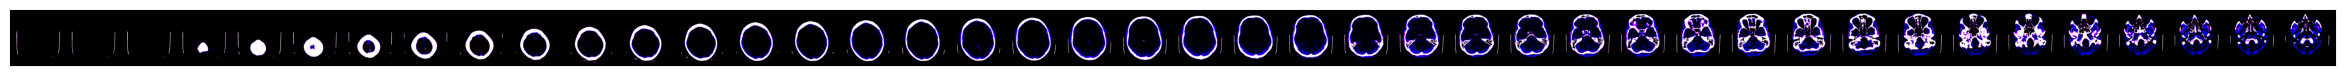

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# torchmil's facilities
from torchmil.visualize.vis_ctscan import slices_to_canvas, draw_slices_contour

BAGS_CSV_PATH = '/data/datasets/RSNA_ICH/bags_train.csv'
IMGS_PATH = '/data/datasets/RSNA_ICH/original/'

df = pd.read_csv(BAGS_CSV_PATH)
bag_names = df['bag_name'].unique()
bag_name = bag_names[2]

bag_df = df[df['bag_name'] == bag_name].sort_values('order')
inst_names = bag_df['instance_name'].values
inst_labels = bag_df['instance_label'].values
inst_names_list = [inst_name.split('.')[0] for inst_name in inst_names]
inst_imgs = [np.load(IMGS_PATH + inst_name + '.npy') for inst_name in inst_names_list]
print("This scan has {} slices".format(len(inst_imgs)))

# Using torchmil's functions
canvas = slices_to_canvas(inst_imgs, 512) 
canvas_contours = draw_slices_contour(canvas, slice_size = 512, contour_prop = 0.05)

fig, ax = plt.subplots(figsize=(30, 20))
ax.imshow((canvas_contours * 255).astype(np.uint8))
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In practice, training a MIL model directly on the slices is computationally intractable. Due to this limitation, MIL models usually operate on pre-computed features extracted from each of the instances. Although <tt>torchmil</tt> allows to define models that receive the original slices as input, in this tutorial we will use the pre-computed features since it is the most common form of alleviating this computational barrier. We have processed the RSNA dataset to be used for MIL binary classification problems. It can be downloaded from [here](https://huggingface.co/datasets/Franblueee/RSNA_ICH_MIL).

We now make use of `torchmil.datasets.RSNAMILDataset` to create an object that serves as a `torch.utils.data.Dataset` dataset and contains RSNA. You only need to provide the `root` to the processed dataset, and the desired `features` and `partition`. See how simple is to instance the train dataset:

In [3]:
from torchmil.datasets import RSNAMILDataset
from sklearn.model_selection import train_test_split

dataset        = RSNAMILDataset( root        = '/data/datasets/RSNA_ICH/MIL_processed/',
                                 features    = 'resnet18',
                                 partition   = 'train')
            
# Split the dataset into train and validation sets
bag_labels = dataset.get_bag_labels()
idx = list(range(len(bag_labels)))
val_prop = 0.2
idx_train, idx_val = train_test_split(idx, test_size=val_prop, random_state=1234, stratify=bag_labels)
train_dataset = dataset.subset(idx_train)
val_dataset = dataset.subset(idx_val)

test_dataset   = RSNAMILDataset( root        = '/data/datasets/RSNA_ICH/MIL_processed/',
                                 features    = 'resnet18',
                                 partition   = 'test')

In <tt>torchmil</tt>, each bag is a `TensorDict`. The different keys correspond to different elements of the bag. In this case, each bag has a feature matrix `X`, the bag label `Y`, and the instance labels `y_inst`. Recall that the instance labels cannot be used during training, they are available only for evaluation purposes.

## Mini-batching of bags

Tipically, the bags in a MIL dataset have different size. This can be a problem when creating mini-batches. To solve this, we use the function `collate_fn` from the [<tt><b>torchmil.data</b></tt>](../api/data/index.md) module. This function creates a mini-batch of bags by padding the bags with zeros to the size of the largest bag in the batch. The function also returns a mask tensor that indicates which instances are real and which are padding.

!!! question "Why not use [`torch.nested`](https://pytorch.org/docs/stable/nested.html)?"
    `torch.nested` offer a more flexible method for handling bags of varying sizes. However, since the PyTorch API for nested tensors is still in the prototype stage, <tt><b>torchmil</b></tt> currently relies on the padding approach.

Let's create the dataloaders and visualize the shape of a mini-batch. Since the RSNA dataset does not have many instances per bag, we can use a `batch_size` of 64 for the train and validation sets.

In [4]:
from torchmil.data import collate_fn

batch_size = 64

# Create dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


it = iter(train_dataloader)
batch = next(it)
data_shape = (batch['X'].shape[-1], )
print("Batch X shape: ", batch['X'].shape)
print("Batch Y shape: ", batch['Y'].shape)
print("Batch y_inst shape: ", batch['y_inst'].shape)
print("Batch mask shape: ", batch['mask'].shape)


Batch X shape:  torch.Size([64, 44, 512])
Batch Y shape:  torch.Size([64])
Batch y_inst shape:  torch.Size([64, 44])
Batch mask shape:  torch.Size([64, 44])


Each batch is again a `TensorDict` with an additional key `mask` that indicates which instances are real and which are padding. As we can see, the bags are padded to the maximum size of the bags in the batch with zeros. The mask tensor indicates which elements are real instances and which are padding. The function `collate_fn` also pads other tensors, such as the adjacency matrix or the instance coordinates. 

## Training a model in RSNA

We have shown how to load the RSNA dataset for the binary classification task. Now, let us train a MIL model in this dataset! For this example, we will use <tt>torchmil</tt> implementation of a [Transformer ABMIL](../api/models/transformer_abmil.md), a version of [ABMIL](../api/models/abmil.md) where a [Transformer Encoder](../api/nn/transformers/conventional_transformer.md) is applied to refine the instances before the [Attention Pool](../api/nn/attention/attention_pool.md). To highlight how simple is to instance a model in <tt>torchmil</tt>, we will leave all the parameters by default except for the `in_shape`, which reflects the data shape. Feel free to check the [documentation of Transformer ABMIL](../api/models/transformer_abmil.md) to observe the different parameters that this model can be passed.

In [10]:
from torchmil.models import TransformerABMIL
model = TransformerABMIL( in_shape = data_shape)

See? It can not be easier! Now, let's train the model. <tt>torchmil</tt> offers an easy-to-use trainer class located in `torchmil.utils.trainer.Trainer` that provides a generic training for any MIL model. Also, it will show the evolution of the losses and the desired metrics during the epochs.

!!! note
    This `Trainer` gives the flexibility to log the results using any wrapped `logger`, use annealing for the loss functions via the `annealing_scheduler_dict` dictionary, or to set a learning rate scheduler using the parameter `lr_scheduler`. Also, you can follow multiple metrics during the training thanks to the parameter `metrics_dict` and the integration with the <tt>torchmetrics</tt> package.

For now, let us just keep it simple and perform a simple training using the `torch.optim.Adam` optimizer and training the model for 10 epochs. First, we instance the trainer.

In [11]:
from torchmil.utils.trainer import Trainer
import torchmetrics
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

trainer = Trainer(  model = model,
                    optimizer = optimizer,
                    metrics_dict = {'auroc' : torchmetrics.AUROC(task='binary').to(device), 'acc': torchmetrics.Accuracy(task='binary').to(device)},
                    obj_metric= 'acc',
                    device = 'cuda')


In [12]:
EPOCHS = 20
trainer.train( max_epochs = EPOCHS,
               train_dataloader= train_dataloader,
               val_dataloader= val_dataloader,
               test_dataloader= test_dataloader)

[Epoch 1] Test : 100%|██████████| 3/3 [00:00<00:00, 50.04it/s, test/loss=0.669, test/BCEWithLogitsLoss=0.669, test/auroc=0.743, test/acc=0.587]


Best acc: -inf, Current acc: 0.625


[Epoch 2] Test : 100%|██████████| 3/3 [00:00<00:00, 52.43it/s, test/loss=0.619, test/BCEWithLogitsLoss=0.619, test/auroc=0.772, test/acc=0.707]


Best acc: 0.625, Current acc: 0.7599999904632568


[Epoch 3] Test : 100%|██████████| 3/3 [00:00<00:00, 55.16it/s, test/loss=0.586, test/BCEWithLogitsLoss=0.586, test/auroc=0.817, test/acc=0.707]


Best acc: 0.7599999904632568, Current acc: 0.7549999952316284
Early stopping count: 1


[Epoch 4] Test : 100%|██████████| 3/3 [00:00<00:00, 55.78it/s, test/loss=0.527, test/BCEWithLogitsLoss=0.527, test/auroc=0.852, test/acc=0.767]


Best acc: 0.7599999904632568, Current acc: 0.7599999904632568


[Epoch 5] Test : 100%|██████████| 3/3 [00:00<00:00, 62.95it/s, test/loss=0.488, test/BCEWithLogitsLoss=0.488, test/auroc=0.868, test/acc=0.78]


Best acc: 0.7599999904632568, Current acc: 0.8100000023841858


[Epoch 6] Test : 100%|██████████| 3/3 [00:00<00:00, 54.75it/s, test/loss=0.475, test/BCEWithLogitsLoss=0.475, test/auroc=0.88, test/acc=0.787]


Best acc: 0.8100000023841858, Current acc: 0.8050000071525574
Early stopping count: 1


[Epoch 7] Test : 100%|██████████| 3/3 [00:00<00:00,  9.02it/s, test/loss=0.468, test/BCEWithLogitsLoss=0.468, test/auroc=0.886, test/acc=0.807]


Best acc: 0.8100000023841858, Current acc: 0.8199999928474426


[Epoch 8] Test : 100%|██████████| 3/3 [00:00<00:00, 61.10it/s, test/loss=0.46, test/BCEWithLogitsLoss=0.46, test/auroc=0.889, test/acc=0.813]


Best acc: 0.8199999928474426, Current acc: 0.8199999928474426


[Epoch 9] Test : 100%|██████████| 3/3 [00:00<00:00, 58.45it/s, test/loss=0.46, test/BCEWithLogitsLoss=0.46, test/auroc=0.895, test/acc=0.807]


Best acc: 0.8199999928474426, Current acc: 0.8299999833106995


[Epoch 10] Test : 100%|██████████| 3/3 [00:00<00:00, 49.78it/s, test/loss=0.49, test/BCEWithLogitsLoss=0.49, test/auroc=0.888, test/acc=0.813]


Best acc: 0.8299999833106995, Current acc: 0.8299999833106995


[Epoch 11] Test : 100%|██████████| 3/3 [00:00<00:00, 61.28it/s, test/loss=0.439, test/BCEWithLogitsLoss=0.439, test/auroc=0.909, test/acc=0.813]


Best acc: 0.8299999833106995, Current acc: 0.8199999928474426
Early stopping count: 1


[Epoch 12] Test : 100%|██████████| 3/3 [00:00<00:00, 57.87it/s, test/loss=0.544, test/BCEWithLogitsLoss=0.544, test/auroc=0.894, test/acc=0.84]


Best acc: 0.8299999833106995, Current acc: 0.824999988079071
Early stopping count: 2


[Epoch 13] Test : 100%|██████████| 3/3 [00:00<00:00, 80.50it/s, test/loss=0.465, test/BCEWithLogitsLoss=0.465, test/auroc=0.9, test/acc=0.833]


Best acc: 0.8299999833106995, Current acc: 0.8199999928474426
Early stopping count: 3


[Epoch 14] Test : 100%|██████████| 3/3 [00:00<00:00, 51.10it/s, test/loss=0.536, test/BCEWithLogitsLoss=0.536, test/auroc=0.898, test/acc=0.813]


Best acc: 0.8299999833106995, Current acc: 0.8349999785423279


[Epoch 15] Test : 100%|██████████| 3/3 [00:00<00:00, 53.78it/s, test/loss=0.531, test/BCEWithLogitsLoss=0.531, test/auroc=0.903, test/acc=0.827]


Best acc: 0.8349999785423279, Current acc: 0.8199999928474426
Early stopping count: 1


[Epoch 16] Test : 100%|██████████| 3/3 [00:00<00:00, 45.51it/s, test/loss=0.534, test/BCEWithLogitsLoss=0.534, test/auroc=0.9, test/acc=0.82]


Best acc: 0.8349999785423279, Current acc: 0.8050000071525574
Early stopping count: 2


[Epoch 17] Test : 100%|██████████| 3/3 [00:00<00:00, 55.66it/s, test/loss=0.712, test/BCEWithLogitsLoss=0.712, test/auroc=0.88, test/acc=0.813]


Best acc: 0.8349999785423279, Current acc: 0.8149999976158142
Early stopping count: 3


[Epoch 18] Test : 100%|██████████| 3/3 [00:00<00:00, 70.03it/s, test/loss=0.698, test/BCEWithLogitsLoss=0.698, test/auroc=0.897, test/acc=0.807]


Best acc: 0.8349999785423279, Current acc: 0.8349999785423279


[Epoch 19] Test : 100%|██████████| 3/3 [00:00<00:00, 71.81it/s, test/loss=0.705, test/BCEWithLogitsLoss=0.705, test/auroc=0.897, test/acc=0.8]


Best acc: 0.8349999785423279, Current acc: 0.8299999833106995
Early stopping count: 1


[Epoch 20] Test : 100%|██████████| 3/3 [00:00<00:00, 89.68it/s, test/loss=0.75, test/BCEWithLogitsLoss=0.75, test/auroc=0.886, test/acc=0.8]


Best acc: 0.8349999785423279, Current acc: 0.8349999785423279


The loss decreases as the model learns to predict the bag labels. The accuracy increases as the model learns to predict the correct bag labels. This is a good sign that the model is learning! 


!!! question "Why is the first epoch much slower?"
    During the first epoch, the data is loaded from the hard drive to the computer's memory, causing a delay in the training.


## Evaluating the model

Let's evaluate the model. We are going to compute the accuracy and f1-score on the test set. The accuracy is the proportion of correctly classified bags, while the f1-score is the harmonic mean of precision and recall. The f1-score is a good metric for imbalanced datasets.
Typically, in MIL datasets, there are many more negative instances than positive instances. In this case, the f1-score will be very useful.

To compute predictions at the instance level, we are going to use the _attention_ values. They indicate the importance given by the model to each instance in the bag. As explained in the [ABMIL](../api/models/abmil.md) paper, in positive bags, the model should give more importance to the positive instances, so the attention values should be higher for positive instances. 

Instance-level predictions have certain caveats due to padding. When performing operations such as normalizing across the bag, it’s crucial to handle padded instances carefully, as they can affect predictions. Additionally, padded instances should be excluded when computing metrics to ensure accuracy.

First, we define some auxiliary functions. Take a look at how we handle padded instances in `normalize`.

In [13]:
def accuracy(pred, y):
    return (pred == y).sum().item() / len(y)

def f1_score(pred, y):
    tp = ((pred == 1) & (y == 1)).sum().item()
    fp = ((pred == 1) & (y == 0)).sum().item()
    fn = ((pred == 0) & (y == 1)).sum().item()
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    return f1

Now, we compute the predictions at both the bag and instance level. Take a look at how we handle the padded instances!

In [16]:
inst_pred_list = []
y_inst_list = []
Y_pred_list = []
Y_list = []

model.eval()

for batch in test_dataloader:
    batch = batch.to(device)
    
    # predict bag label and attention
    out = model(batch['X'], batch['mask'])
    Y_pred = (out > 0).float()

    Y_pred_list.append(Y_pred)
    Y_list.append(batch['Y'])

Y_pred = torch.cat(Y_pred_list)
Y = torch.cat(Y_list)

print(f"test/bag/acc: {accuracy(Y_pred, Y)}")
print(f"test/bag/f1: {f1_score(Y_pred, Y)}")

test/bag/acc: 0.8
test/bag/f1: 0.7857137748982771


Good! Our model is working well. The accuracy and f1-score are high. This means that the attention values are correctly indicating the importance of the instances in the bag. Let's visualize the attention values for some bags.